In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------
# converts degrees to radians
deg2rad = np.pi / 180.0
# ----------------------------------
# converts degrees to radians
rad2deg = 1.0 / deg2rad

In [21]:
def density_function_dists(dists, gammas=20, radkm=100, epsilons=8000):
    # auxilary function
    sx = (dists - radkm) / epsilons

    # Boolean indexes
    # point closer to the center
    closer_to_center = (dists <= radkm)

    # point in transition zone
    transition_zone = (dists <= radkm + epsilons) & (dists > radkm)

    # point far from the center
    far_from_center = (dists > radkm + epsilons)

    # set density
    dens_f = np.zeros(np.shape(dists))
    dens_f[closer_to_center] = gammas ** 4
    dens_f[transition_zone] = ((1.0 - sx[transition_zone]) *
                               gammas + sx[transition_zone]) ** 4
    dens_f[far_from_center] = 1.0

    # normalization - make it in [0,1]
    dens_f = dens_f / gammas ** 4
    return dens_f

def density_function(lat, lon, **kwargs):
    lat, lon = map(np.radians, [lat, lon])

    haver_formula = np.sin(lat / 2.0) ** 2 + \
                    np.cos(lat) * np.sin(lon / 2.0) ** 2

    dists = 2 * np.arcsin(np.sqrt(haver_formula)) * 6367

    dens_f = density_function_dists(dists, **kwargs)
    return dens_f

In [22]:
nlat = 1024*2
nlon = 2048*2

lats = np.linspace(-90.0, 90.0, nlat + 1)
lons = np.linspace(-180.0, 180.0, nlon + 1)
lons, lats = np.meshgrid(lons, lats)

# compute the density function in the lat-lon grid
print("Computing the density function in the lat-lon grid...")
data = density_function(lats, lons, gammas=20, radkm=100, epsilons=8000)
print("Done\n")

Computing the density function in the lat-lon grid...
Done



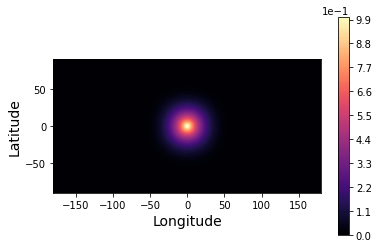

In [23]:
plt.figure()

# plot contours
#plt.contour(lons, lats, data, colors='black')
cp = plt.contourf(lons, lats, data, 100, cmap='magma')

# label the axis
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# plot colobar
cbar = plt.colorbar(cp)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# show, save and close
plt.gca().set_aspect('equal')
plt.show()
plt.close()

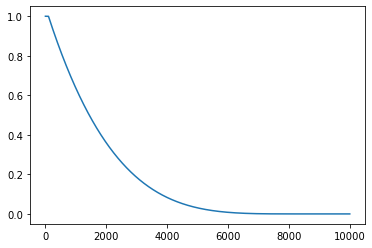

In [24]:
dists = np.linspace(0.0, 10000.0, 50000)
dens = density_function_dists(dists)

plt.plot(dists, dens)
plt.show()
plt.close()

1784.7219114533852
10000.0


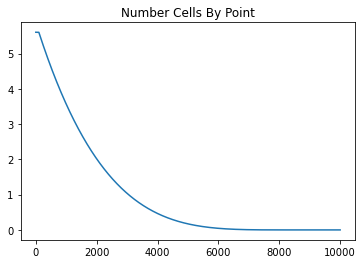

In [6]:
def density_to_resolution(dens, N=200000):
    sum_dens = dens.sum()
    print(sum_dens)

    res = N * dens / sum_dens
    return res

# From 0 to 10k km of the center we create a 1D grid
dists = np.arange(0, 10000.0, 1)
dens = density_function_dists(dists)

# In the grid covered by "dens" we want to put 10k cells
cells_by_point = density_to_resolution(dens, N=10000)

num_cells = cells_by_point.sum()
print(num_cells)

plt.plot(dists, cells_by_point)
plt.title("Number Cells By Point")
plt.show()
plt.close()

Computing the density function in the lat-lon grid...


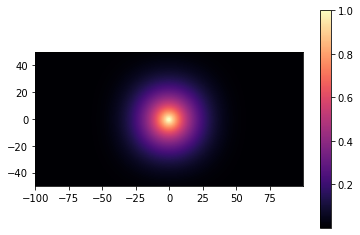

1600000.0000000002


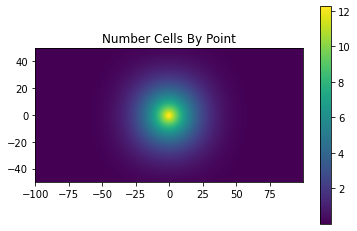

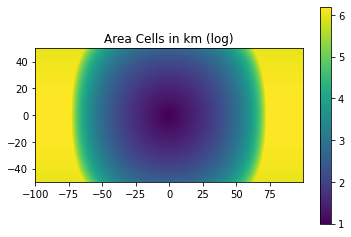

In [33]:
N_cells = 1600000
step = 0.1
lats0 = np.arange(-50.0, 50.0, step)
lons0 = np.arange(-100.0, 100.0, step)

lons, lats = np.meshgrid(lons0, lats0)

def areas(lat, lon, step=0.1):
    stepv = np.full(lat.shape, step)
    latsY = stepv*110
    lonsX = step*110*abs(np.cos(np.radians(lats)))
    area = latsY*lonsX
    return area

area = areas(lons, lats, step=step)

# compute the density function in the lat-lon grid
print("Computing the density function in the lat-lon grid...")
data = density_function(lats, lons, gammas=20, radkm=100, epsilons=8000)


fig, ax = plt.subplots()
im = ax.pcolormesh(lons, lats, data, shading='nearest', cmap='magma')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)
plt.show()

sum_dens = data.sum()
cells_by_point = data*N_cells/sum_dens
num_cells = cells_by_point.sum()
print(num_cells)

fig, ax = plt.subplots()
im = ax.pcolormesh(lons, lats, cells_by_point, shading='nearest', cmap='viridis')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)

plt.title("Number Cells By Point")
plt.show()
plt.close()

area_cells = area/cells_by_point

fig, ax = plt.subplots()
im = ax.pcolormesh(lons, lats, np.log10(area_cells), shading='nearest', cmap='viridis')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)

plt.title("Area Cells in km (log)")
plt.show()
plt.close()

(1000, 2000)
(2000,)


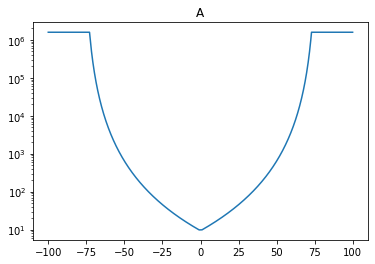

(100,)


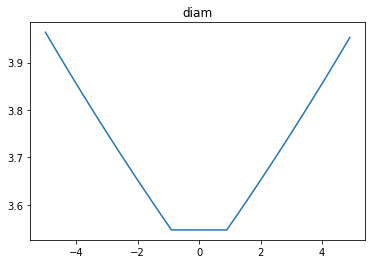

In [34]:
print(area_cells.shape)
rangeareas = area_cells[len(lats0)//2, :]
print(rangeareas.shape)
plt.plot(lons0, rangeareas)
plt.yscale('log')
plt.title("A")
plt.show()
plt.close()

resolution_cells = 2*np.sqrt(area_cells/np.pi)
rangeres= resolution_cells[len(lats0)//2, len(lons0)//2-50:len(lons0)//2+50]
print(rangeres.shape)
plt.plot(lons0[len(lons0)//2-50:len(lons0)//2+50], rangeres)
plt.title("diam")
plt.show()
plt.close()

7753.340331044212
Needed cells for lower resolution 1km
1194495.0011063365
(100,)


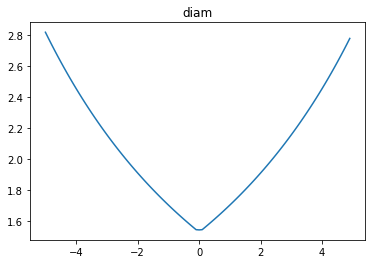

In [51]:
def dens2res(N_cells, step=0.1, gammas=20, 
             radkm=100, epsilons=8000, plot=True):
    
    lats0 = np.arange(-50.0, 50.0, step)
    lons0 = np.arange(-100.0, 100.0, step)

    lons, lats = np.meshgrid(lons0, lats0)

    area = areas(lons, lats, step=step)
    
    dens = density_function(lats, lons, 
                            gammas=gammas, 
                            radkm=radkm, 
                            epsilons=epsilons)
    
    sum_dens = dens.sum()
    print(sum_dens)
    
    neededNcells = (2*110*step)**2/np.pi * sum_dens
    
    print('Needed cells for lower resolution 1km')
    print(neededNcells)
    
    cells_by_point = dens*N_cells/sum_dens
    
    area_cells = area/cells_by_point
    
    resolution_cells = 2*np.sqrt(area_cells/np.pi)
    
    if plot:
        rangeres= resolution_cells[len(lats0)//2, len(lons0)//2-50:len(lons0)//2+50]
        print(rangeres.shape)
        plt.plot(lons0[len(lons0)//2-50:len(lons0)//2+50], rangeres)
        plt.title("diam")
        plt.show()
        plt.close()
        
    return resolution_cells
    
res = dens2res(500000, step=0.1, gammas=20, radkm=10, epsilons=2000)

In [ ]:
uarea2res(0.000002)

In [ ]:
uarea2res(0.000548)

In [ ]:
# gamma 15, m 200, epsilons 8000
d = densf_vec(latY, lonX, gammas=15, radkm=200, epsilons=8000)

fig, ax = plt.subplots()
im = ax.pcolormesh(lonX, latY, d, shading='nearest', cmap='magma')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)
plt.show()

mina = 0.0000478
maxa = 0.47365
minres = uarea2res(mina)
maxres = uarea2res(maxa)
print(minres, maxres, maxres/minres, maxa/mina)

In [ ]:
# gamma 20, m 100, epsilons 8000
d = densf_vec(latY, lonX, gammas=20, radkm=100, epsilons=8000)

fig, ax = plt.subplots()
im = ax.pcolormesh(lonX, latY, d, shading='nearest', cmap='magma')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)
plt.show()

mina = 0.000011
maxa = 0.264887
minres = uarea2res(mina)
maxres = uarea2res(maxa)
print(minres, maxres, maxres/minres, maxa/mina)